In [1]:
!nvidia-smi

Fri Sep  5 16:37:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 39%   45C    P8             18W /  170W |     652MiB /  12288MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from PIL import Image
import torch
import cv2
from diffusers import ControlNetModel, AutoPipelineForImage2Image, StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image, make_image_grid
import numpy as np
import base64
from io import BytesIO
from PIL import Image
import numpy as np
from transformers import pipeline
import gc

In [3]:
controlnet = ControlNetModel.from_pretrained(
             "diffusers/controlnet-depth-sdxl-1.0", # Smaller Depth ControlNet model
            torch_dtype=torch.float16,
            variant="fp16",
            use_safetensors=True
        ).to("cuda")
sdxl = AutoPipelineForImage2Image.from_pretrained(
            "stabilityai/stable-diffusion-xl-base-1.0", # Faster Turbo model
            controlnet=controlnet,
            torch_dtype = torch.float16,
            variant = "fp16",
            use_safetensors=True
        ).to("cuda")

sdxl.enable_model_cpu_offload()

depth_estimator = pipeline(
    task="depth-estimation",
    model="Intel/zoedepth-nyu-kitti",
    dtype=torch.float32,
    device= -1,
    use_fast = True
)

refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0", 
    torch_dtype=torch.float16, 
    variant="fp16", 
    use_safetensors=True
)
refiner.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
def encode_base64(image: Image.Image, image_format: str = "PNG") -> str:
    """
    Encode a PIL image to a base64 string.

    Parameters:
        image (Image.Image): The PIL image to encode.
        image_format (str): Image format to use ("PNG", "JPEG", etc.)

    Returns:
        str: Base64-encoded image string.
    """
    buffered = BytesIO()
    image.save(buffered, format=image_format)

    img64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    if img64 is None:
        raise TypeError("Please check this goddam function")

    return img64


def normalize_depth(depth: np.ndarray, clip_percentiles=(1,99), invert=False):
    lo, hi = np.percentile(depth, clip_percentiles)
    depth = np.clip(depth, lo, hi)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    if invert:
        depth = 1.0 - depth
    return depth

def depth_to_uint8_rgb(depth: np.ndarray, invert=False):
    d = normalize_depth(depth, invert=invert)
    img8 = (d * 255.0).astype(np.uint8)
    rgb = np.stack([img8, img8, img8], axis=-1)
    return Image.fromarray(rgb)

def depth_to_uint16_rgb(depth: np.ndarray, invert=False):
    d = normalize_depth(depth, invert=invert)
    img16 = (d * 65535.0).astype(np.uint16)
    # Pillow needs mode='I;16' handling per-channel; easier to save as single channel then convert in your pipeline
    return img16

def preprocess_img(img: Image):
    """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""
    results = depth_estimator(img)["depth"]
    control_img = depth_to_uint8_rgb(results, invert=True)
    img_np = np.array(control_img)

    # FIX: Convert the 3-channel RGB image to a single-channel grayscale image
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # Create the CLAHE object
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    # Now, apply CLAHE to the grayscale image
    contrast_img = clahe.apply(gray_img)

    final_image = Image.fromarray(contrast_img)


    return final_image


def base_64_to_pil(base64_str: str):
    if ',' in base64_str:
        base64_str = base64_str.split(',')[1]


    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    return image

In [5]:
def infer(url, steps, net, guid, res: int):
    img = load_image(url).resize((res, res), Image.LANCZOS)
    control_image = preprocess_img_c(img)
    print('created control image...')
    prompt = "close-up studio portrait of a newborn baby, " \
    "asleep, tiny eyelashes, soft natural skin," \
    " gentle rosy cheeks, subtle peach fuzz, relaxed lips, serene expression," \
    " warm diffused softbox lighting, clean black background, the babie's face clearly in focus" \
    "shallow depth of field, 85mm photo look, ultra-detailed realistic skin texture,"
   # " high dynamic range, professional newborn photography, photorealistic, 1:1"

    negative_prompt =  "Text, hair, clay or plastic skin, CGI, doll-like, uncanny, deformed or asymmetrical facial features, " \
    "extra fingers or limbs, multiple faces, open eyes, teeth, adult traits, stubble, "

    b =    "heavy makeup, jewelry, medical equipment, umbilical cord, placenta, " \
    "occluded face, hands covering face, harsh shadows, blown highlights, " \
    "over-sharpening halos, banding, text, watermark, logo, low-res, blurry, " \
    "oversaturated, cartoon, painting, anime"


    num_inference_steps = steps
    controlnet_conditioning_scale = net
    guidance = guid


    # Run batch if your pipeline supports it
    output_images = []


    with torch.inference_mode():
        tmp = sdxl(
            image=img,
            prompt= prompt,
            negative_prompt=negative_prompt,
            control_image=control_image,
            guidance_scale=guidance,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            num_inference_steps=num_inference_steps,

            height=res,
            width=res
        ).images
        output_images.append(tmp[0])
        del tmp, control_image, img




    # Convert to base64
    output_images = [encode_base64(image) for image in output_images]
    gc.collect()
    torch.cuda.empty_cache()
    return {"images": output_images}




In [29]:
def preprocess_img_c(img: Image):
    """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""
    results = depth_estimator(img)["depth"]

    adjusted_image = cv2.convertScaleAbs(np.array(results), alpha= 1.8, beta=0)
    control_img = depth_to_uint8_rgb(adjusted_image, invert=True)

    img_np = np.array(control_img)

    # FIX: Convert the 3-channel RGB image to a single-channel grayscale image
    gray_img = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)


    final_image = Image.fromarray(gray_img)


    return final_image

def preprocess_img_c(img: Image, res: tuple[int, int] = (512, 512)):

    """Preprocesses the input image: Load, Grayscale, Resize, CLAHE, Denoise, Sharpen, Convert to RGB."""


    kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])

    try:
        # Load image, convert to grayscale, resize
        img = img.convert("L")


    except Exception as e:
        print(f"Error opening or processing image: {e}")
        return None
 


    img_np = np.array(img)

    # Apply CLAHE for contrast enhancement

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    contrast_img = clahe.apply(img_np)

    # Denoise the image first
    denoised_img = cv2.fastNlMeansDenoising(contrast_img, h=7) # Denoising strength
    # Sharpen the denoised image
    sharpened_img = cv2.filter2D(denoised_img, -1, kernel) 
    final = Image.fromarray(sharpened_img)


    # Convert final grayscale image to RGB for the pipeline input


    return final.convert("RGB")



In [30]:
torch.cuda.empty_cache()
gc.collect()

0

In [46]:

url = f"/home/yahir-luna/Documents/aa.png"

prompt = "close-up studio portrait of a newborn baby, " \
"asleep, tiny eyelashes, soft natural skin," \
" gentle rosy cheeks, subtle peach fuzz, relaxed lips, serene expression," \
" warm diffused softbox lighting, clean black background, the babie's face clearly in focus" \
"shallow depth of field, 85mm photo look, ultra-detailed realistic skin texture,"

img = Image.open(url).resize((512, 512), Image.LANCZOS)
imgs = infer(url, 14, 0.35,13, 512)
control = preprocess_img_c(img)
print(control.size)
img_after = base_64_to_pil(imgs['images'][0])




created control image...


  0%|          | 0/11 [00:00<?, ?it/s]

(512, 512)


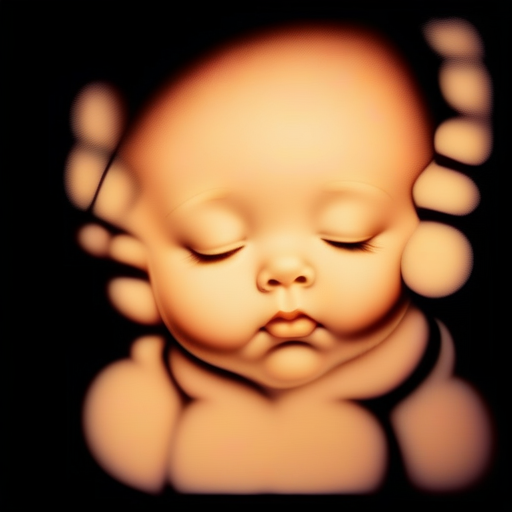

In [47]:
img_after

In [ ]:
negative_prompt =  "Text, hair, clay or plastic skin, CGI, doll-like, uncanny, deformed or asymmetrical facial features, " \
    "extra fingers or limbs, multiple faces, open eyes, teeth, adult traits, stubble, "

b =    "heavy makeup, jewelry, medical equipment, umbilical cord, placenta, " \
"occluded face, hands covering face, harsh shadows, blown highlights, " \
"over-sharpening halos, banding, text, watermark, logo, low-res, blurry, " \
"oversaturated, cartoon, painting, anime"

enhanced = refiner(prompt = prompt, 
                   negative_prompt=negative_prompt, 
                   image = img_after
                   )

  0%|          | 0/15 [00:00<?, ?it/s]

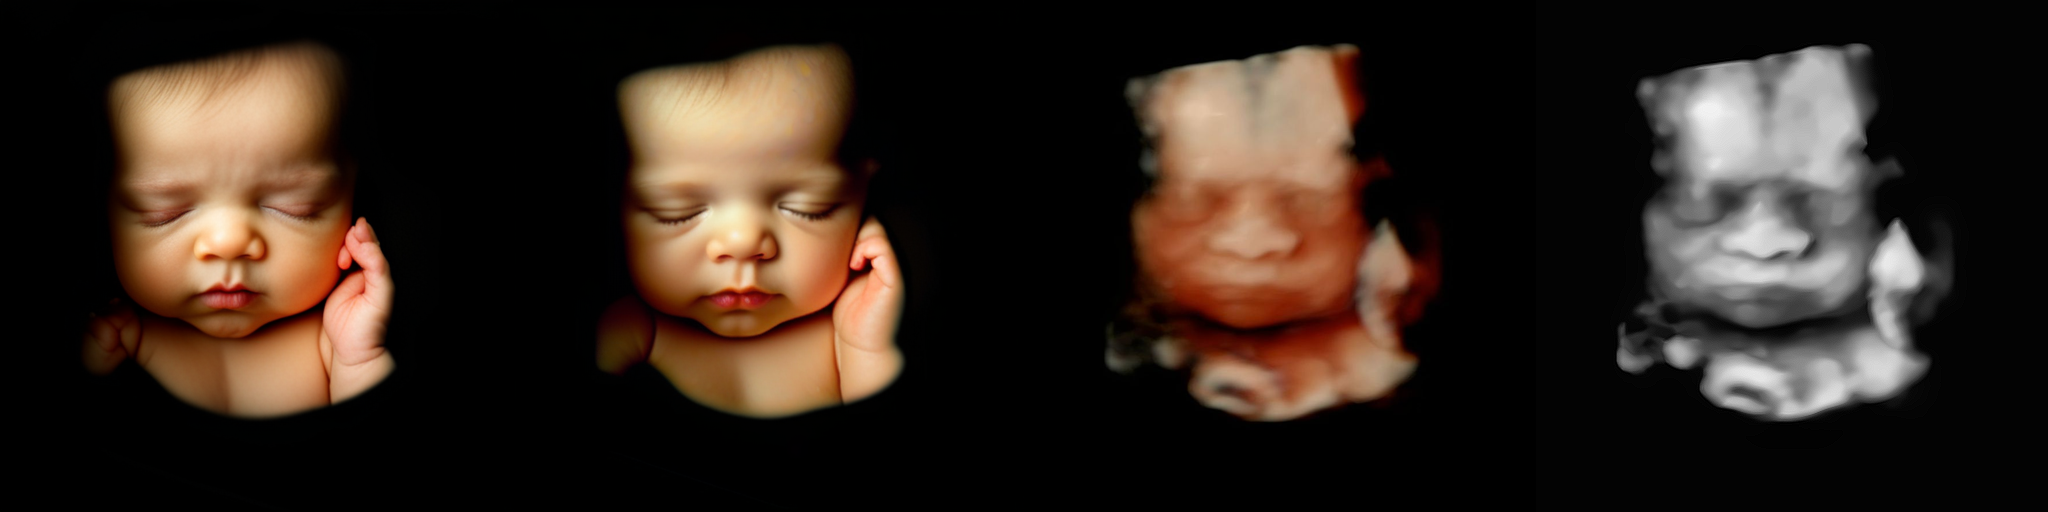

In [34]:
make_image_grid([enhanced['images'][0], img_after, img, control],1,4)